## Описание проекта

Компания-агрегатор такси собрала исторические данные о заказах такси в аэропортах. Задача - спрогнозировать (построить модель) количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*'.

# 1. Подготовка

In [1]:
# Импортируем необходимые библитеки и методы
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

In [2]:
# Читаем исходный файл, не забывая о индексировании и сортировке дат
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
# Смотрим общую информацию
print('INFO')
display(data.info())
print('HEAD 10')
display(data.head(10))
print('DESCRIBE')
display(data.describe())
print('SPACES')
display(data.isnull().sum())
print('DUPLICATES')
display(data.duplicated().sum())
print('DIMENSION')
data.shape

INFO
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


None

HEAD 10


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


DESCRIBE


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


SPACES


num_orders    0
dtype: int64

DUPLICATES


26415

DIMENSION


(26496, 1)

В соответствии с условиями задачи, проведем ресемплирование (1 час)

In [4]:
data = data.resample('1H').sum()

In [5]:
print('INFO')
display(data.info())
print('HEAD 10')
display(data.head(10))

INFO
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


None

HEAD 10


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Оценим графически

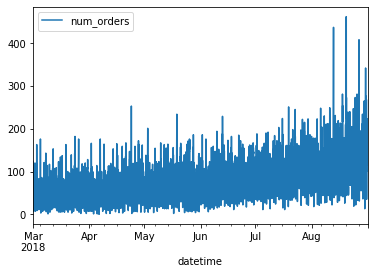

In [6]:
data.plot()

## 1. Подготовка. Выводы.

- исходный датасет представлен 26 496 записями и 1 признаком
- названия столбцов информативны и удобочитаемы
- пропущенных значений нет
- наличие дубликатов легко объяснимо одинаковым количеством заказов такси в разные дни
- произведено ресемплирование до интервала в 1 час (изначальный интервал = 10 мин.)

# 2. Анализ

Оценим тренды и сезонность

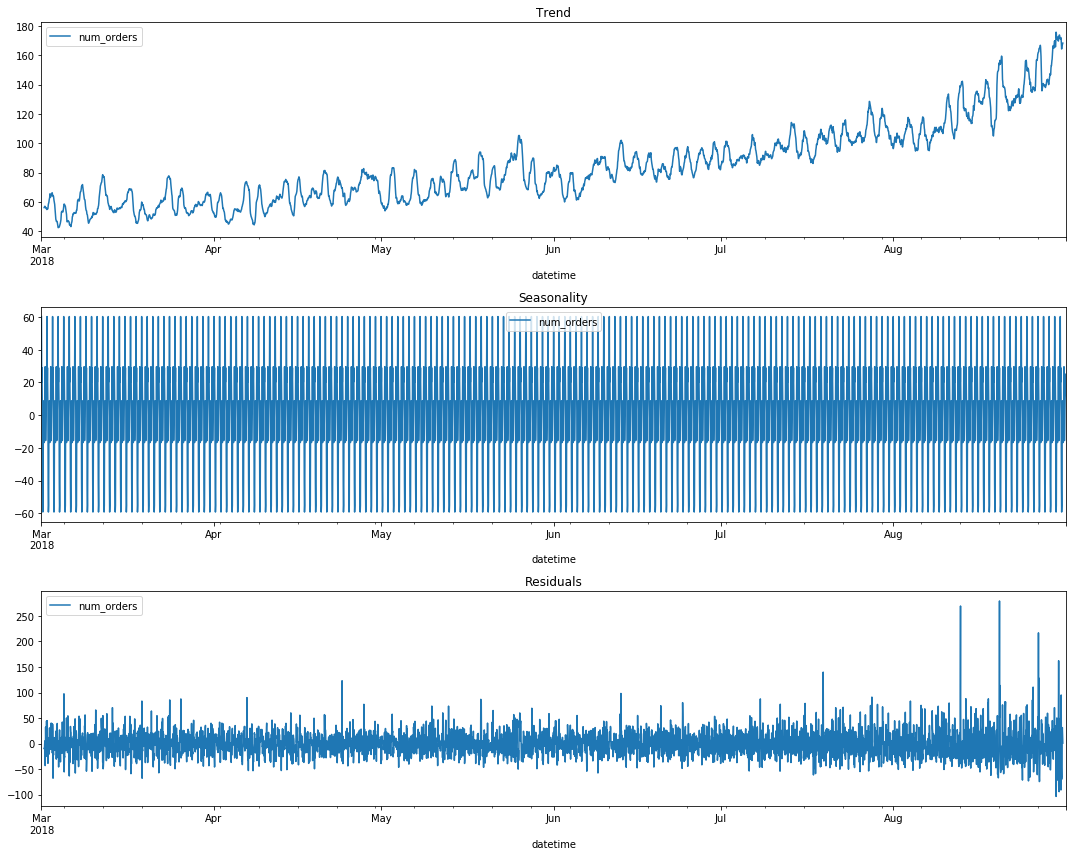

In [7]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Углубимся до часов

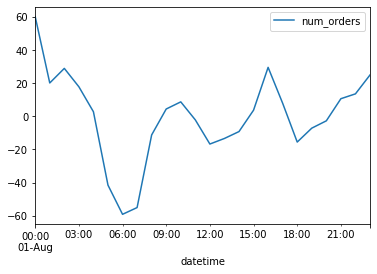

In [8]:
decomposed.seasonal['2018-08-01':'2018-08-01'].plot(ax=plt.gca())

# 2. Анализ. Выводы.

- датасет представляет из себя временной ряд с диапазаном данных по количеству заказов такси с `2018-03-01` по `2018-08-31`
- временной ряд не является стационарным, так как от начала ряда до конца меняется среднее значение на месячном временном диапазоне
- анализ тренда и сезонности показывает следующие закономерности:  
    - Тренд. Непрерывно растущий, с марта (в районе 55 заказов в час) до августа (около 130 заказов в час)
    - Сезоность. При заданном ресемплировании "сезон" = 24 часа. На примере одной из дат наблюдается рост от среднего, вечером с 18.00 до 00.00, падение в ночное время с 00.00 до 06.00, рост в утреннее время с 06.00 до 10.00 и колебание вокруг среднего значения в остальное дневное время

# 3. Обучение

### 3.1. Создаем признаки для модели

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    #Календарные признаки 
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    #Отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    #Скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [10]:
make_features(data, 6, 2)
data = data.dropna()
print('INFO')
display(data.info())
print('HEAD 10')
display(data.head(10))

INFO
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4410 entries, 2018-03-01 06:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 13 columns):
num_orders      4410 non-null int64
year            4410 non-null int64
month           4410 non-null int64
day             4410 non-null int64
dayofweek       4410 non-null int64
hour            4410 non-null int64
lag_1           4410 non-null float64
lag_2           4410 non-null float64
lag_3           4410 non-null float64
lag_4           4410 non-null float64
lag_5           4410 non-null float64
lag_6           4410 non-null float64
rolling_mean    4410 non-null float64
dtypes: float64(7), int64(6)
memory usage: 482.3 KB


None

HEAD 10


,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 06:00:00,12,2018,3,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,24.5
2018-03-01 07:00:00,15,2018,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,9.0
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,13.5
2018-03-01 09:00:00,69,2018,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,24.5
2018-03-01 10:00:00,64,2018,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,51.5
2018-03-01 11:00:00,96,2018,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,66.5
2018-03-01 12:00:00,30,2018,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,80.0
2018-03-01 13:00:00,32,2018,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,63.0
2018-03-01 14:00:00,48,2018,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,31.0


### 3.2. Делим датасет на обучающую, валидационную и тестовую выборки

In [11]:
# Проведем последовательное разбиение. Сначала разделим датасет на обучающую и валидационную выборки (80% отдаем обучающей)
train, valid = train_test_split(data, test_size = 0.2, shuffle = False)

# Теперь поделим пополам валидационную выборку, тем самым создав тестовую
valid, test = train_test_split(valid, test_size = 0.5, shuffle = False)

# Контрольная проверка размерности выборок
print('Размерность обучащей выборки:', train.shape)
print('Размерность валидационной выборки:', valid.shape)
print('Размерность тестовой выборки:', test.shape)

Размерность обучащей выборки: (3528, 13)
Размерность валидационной выборки: (441, 13)
Размерность тестовой выборки: (441, 13)


Создаем переменные для признаков и целевого признака

In [12]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Проверяем соблюдение последовательности временного ряда

In [13]:
print("Обучающая выборка:",train.index.min(), train.index.max())
print("Валидная выборка:",valid.index.min(), valid.index.max())
print("Тестовая выборка:",test.index.min(), test.index.max())

Обучающая выборка: 2018-03-01 06:00:00 2018-07-26 05:00:00
Валидная выборка: 2018-07-26 06:00:00 2018-08-13 14:00:00
Тестовая выборка: 2018-08-13 15:00:00 2018-08-31 23:00:00


In [14]:
features_train_valid = pd.concat([features_train,features_valid], ignore_index=False)
features_train_valid.sort_index(inplace=True)
target_train_valid = pd.concat([target_train,target_valid], ignore_index=False)
target_train_valid.sort_index(inplace=True)

#Проверяем соблюденик последовательности временного ряда train+valid
print("features_train_valid выборка:",features_train_valid.index.min(), features_train_valid.index.max())
print()
print("target_train_valid выборка:",target_train_valid.index.min(), target_train_valid.index.max())

features_train_valid выборка: 2018-03-01 06:00:00 2018-08-13 14:00:00

target_train_valid выборка: 2018-03-01 06:00:00 2018-08-13 14:00:00


### 3.3. Применяем алгоритм прогнозирования на базе прогноза предыдущим значением

In [15]:
print("Среднее количество заказов в день:", test['num_orders'].mean())

pred_previous = test['num_orders'].shift(fill_value=0)
pred_previous.iloc[0] = valid['num_orders'].iloc[-1]

print("RMSE прогноз предыдущим значением:", sqrt(mean_squared_error(test['num_orders'], pred_previous)))

Среднее количество заказов в день: 139.64172335600907
RMSE прогноз предыдущим значением: 58.91761802963282


Алгоритм прогнозирования на базе прогноза предыдущим значением показал RMSE = 58.9. Это хуже необходимого нам целевого значения = 48

### 3.4. Обучение алгоритмом LinearRegression

In [16]:
%%time
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
predicted_LR_valid = model_LR.predict(features_valid)
rmse_LR = sqrt(mean_squared_error(target_valid, predicted_LR_valid))
print('RMSE LinearRegression = ',int(rmse_LR), '\n')

RMSE LinearRegression =  40 

CPU times: user 8.2 ms, sys: 661 µs, total: 8.86 ms
Wall time: 4.56 ms


### 3.5. Обучение алгоритмом DecisionTreeRegressor

In [17]:
%%time
i=0
result = pd.DataFrame(columns=['max_depth', 'RMSE_DTR'])
for max_depth in range(1,51,5):
    model_DTR = DecisionTreeRegressor(random_state=12345, max_depth = max_depth)    
    model_DTR.fit(features_train, target_train)
    predicted_DTR_valid = model_DTR.predict(features_valid)
    rmse_DTR = sqrt(mean_squared_error(target_valid, predicted_DTR_valid))    
    result.loc[i] = [max_depth, rmse_DTR]
    i+=1
result.sort_values('RMSE_DTR')

CPU times: user 359 ms, sys: 33.3 ms, total: 393 ms
Wall time: 404 ms


,max_depth,RMSE_DTR
1,6.0,37.059833
2,11.0,38.481580
5,26.0,40.849872
6,31.0,40.849872
7,36.0,40.849872
8,41.0,40.849872
9,46.0,40.849872
3,16.0,41.283825
4,21.0,41.368388
0,1.0,51.429266


Для алгоритма DecisionTreeRegressor, оптимальное значение гипермараметра max_depth = 6 (RMSE = 37.059833)

### 3.6. Обучение алгоритмом RandomForestRegressor

In [18]:
%%time
i=0
result = pd.DataFrame(columns=['estimators', 'RMSE_RFR'])
 
for estimators in range(20,101,10):
    model_RFR = RandomForestRegressor(random_state = 12345, n_estimators= estimators)
    model_RFR.fit(features_train, target_train)
    predicted_RFR_valid = model_RFR.predict(features_valid)
    rmse_RFR = sqrt(mean_squared_error(target_valid, predicted_RFR_valid))    
    result.loc[i] = [estimators, rmse_RFR]
    i+=1
result.sort_values('RMSE_RFR')

CPU times: user 12.4 s, sys: 41.4 ms, total: 12.4 s
Wall time: 12.4 s


,estimators,RMSE_RFR
8,100.0,33.118702
2,40.0,33.139636
5,70.0,33.205278
7,90.0,33.229520
6,80.0,33.232905
3,50.0,33.253622
4,60.0,33.308601
1,30.0,33.392947
0,20.0,33.919241


Для алгоритма RandomForestRegressor, оптимальное значение гипермараметра n_estimators = 100 (RMSE = 33.118702)

# 4. Тестирование

Применяем обученную алгоритмами модель, c оптимальными гиперпараметрами, к тестовой выборке

### 4.1. LinearRegression test

In [19]:
%%time
model_LR = LinearRegression()
model_LR.fit(features_train_valid, target_train_valid)
pred_LR_test = model_LR.predict(features_test)
rmse_LR = sqrt(mean_squared_error(target_test, pred_LR_test))
print('RMSE LinearRegression test= ',int(rmse_LR), '\n')

RMSE LinearRegression test=  53 

CPU times: user 13.3 ms, sys: 252 µs, total: 13.6 ms
Wall time: 18.2 ms


### 4.2. DecisionTreeRegressor test

In [20]:
%%time
model_DTR = DecisionTreeRegressor(random_state = 12345, max_depth = 6)
model_DTR.fit(features_train_valid, target_train_valid)
pred_DTR_test = model_DTR.predict(features_test)
rmse_DTR = sqrt(mean_squared_error(target_test, pred_DTR_test))
print('RMSE DecisionTreeRegressor test= ',int(rmse_DTR), '\n')

RMSE DecisionTreeRegressor test=  55 

CPU times: user 32.4 ms, sys: 20 ms, total: 52.4 ms
Wall time: 18.4 ms


### 4.3. RandomForestRegressor test

In [21]:
%%time
model_RFR = RandomForestRegressor(random_state = 12345, n_estimators= 100)
model_RFR.fit(features_train_valid, target_train_valid)
pred_RFR_test = model_RFR.predict(features_test)
rmse_RFR = sqrt(mean_squared_error(target_test, pred_RFR_test))
print('RMSE RandomForestRegressor test= ',int(rmse_RFR), '\n')

RMSE RandomForestRegressor test=  46 

CPU times: user 2.6 s, sys: 43.5 ms, total: 2.64 s
Wall time: 2.67 s


# 5. Выводы

#### Цель исследования
Cпрогнозировать количество заказов такси на следующий час с качеством модели RMSE не более 48 

#### Описание исследования
- датасет представляет из себя временной ряд с диапазаном данных по количеству заказов такси с `2018-03-01` по `2018-08-31`
- временной ряд не является стационарным, так как от начала ряда до конца меняется среднее значение на месячном временном диапазоне
- анализ тренда и сезонности показывает следующие закономерности:  
    - Тренд. Непрерывно растущий, с марта (в районе 55 заказов в час) до августа (около 130 заказов в час)
    - Сезоность. При заданном ресемплировании "сезон" = 24 часа. На примере одной из дат наблюдается рост от среднего, вечером с 18.00 до 00.00, падение в ночное время с 00.00 до 06.00, рост в утреннее время с 06.00 до 10.00 и колебание вокруг среднего значения в остальное дневное время
- алгоритм прогнозирования на базе прогноза предыдущим значением показал на обучающей выборке RMSE = 58.9, что хуже целевого значения 48
- в ходе обучения были протестированы алгоритмы LinearRegression, DecisionTreeRegressor, RandomForestRegressor, с различными гипермпараметрами. 

#### Результат
- после обучения наилучший результат на тестовой выборке показал алгоритм RandomForestRegressor(random_state=12345,n_estimators= 100) с RMSE = 46

===================================================================================================================

#### Благодарю за внимание.
